# Random Forest for Steering Classification

This notebook trains and evaluates Random Forest on the steering image dataset.

**Key Concepts:**
- Extension of bagging with random feature selection at each split
- At each split, consider only m random features (typically √p for classification)
- Decorrelates trees, further reducing variance
- One of the best-performing methods in practice


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

from utils import (
    load_data, preprocess_data, evaluate_model, 
    save_results, print_class_distribution, CLASSES, RANDOM_STATE
)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load and Preprocess Data


In [2]:
# Load data
data = load_data()

X_raw, y_raw = data['raw']
X_eng, y_eng, feature_names = data['engineered']

print("Preprocessing RAW data with PCA:")
raw_processed = preprocess_data(
    X_raw, y_raw, 
    test_size=0.2, 
    apply_pca_reduction=True, 
    pca_variance=0.95,
    scale=False
)

print("\nPreprocessing ENGINEERED data:")
eng_processed = preprocess_data(
    X_eng, y_eng, 
    test_size=0.2, 
    apply_pca_reduction=False,
    scale=False
)

print("\nTraining set class distribution:")
print_class_distribution(raw_processed['y_train'], raw_processed['label_encoder'])


Loaded 9900 raw images
  Shape: (9900, 4096)
  Class distribution: {np.str_('forward'): np.int64(7343), np.str_('left'): np.int64(1620), np.str_('right'): np.int64(937)}
Loaded 9900 samples with 38 engineered features
  Class distribution: {'forward': np.int64(7343), 'left': np.int64(1620), 'right': np.int64(937)}
Preprocessing RAW data with PCA:
Train/Test split: 7920/1980 samples
PCA: 4096 features -> 40 components
  Variance retained: 95.02%

Preprocessing ENGINEERED data:
Train/Test split: 7920/1980 samples

Training set class distribution:
Class Distribution:
  forward: 5874 (74.2%)
  left: 1296 (16.4%)
  right: 750 (9.5%)


## 2. Hyperparameter Tuning


In [3]:
# Grid search for Random Forest on RAW features
print("Tuning Random Forest on RAW (PCA) features...")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5]
}

rf_raw = RandomForestClassifier(
    class_weight='balanced',
    oob_score=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search_raw = GridSearchCV(
    rf_raw, param_grid, cv=skf, scoring='f1_macro', n_jobs=-1, verbose=1
)
grid_search_raw.fit(raw_processed['X_train'], raw_processed['y_train'])

print(f"\nBest parameters: {grid_search_raw.best_params_}")
print(f"Best CV F1 score: {grid_search_raw.best_score_:.4f}")


Tuning Random Forest on RAW (PCA) features...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1 score: 0.8840


In [4]:
# Grid search for Random Forest on ENGINEERED features
print("Tuning Random Forest on ENGINEERED features...")

grid_search_eng = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', oob_score=True, random_state=RANDOM_STATE, n_jobs=-1),
    param_grid, cv=skf, scoring='f1_macro', n_jobs=-1, verbose=1
)
grid_search_eng.fit(eng_processed['X_train'], eng_processed['y_train'])

print(f"\nBest parameters: {grid_search_eng.best_params_}")
print(f"Best CV F1 score: {grid_search_eng.best_score_:.4f}")


Tuning Random Forest on ENGINEERED features...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Best CV F1 score: 0.8442


## 3. Evaluate Best Models


Evaluating best Random Forest on RAW (PCA) features...
OOB Score: 0.9259

Model: Random Forest | Features: raw
Accuracy:          0.9232
Balanced Accuracy: 0.8554
Macro F1:          0.8796
Weighted F1:       0.9211
Macro Precision:   0.9111
Macro Recall:      0.8554
ROC-AUC (macro):   0.9809

Per-class metrics:
  forward   : F1=0.9495, Precision=0.9279, Recall=0.9721
  left      : F1=0.8253, Precision=0.9269, Recall=0.7438
  right     : F1=0.8641, Precision=0.8785, Recall=0.8503

Classification Report:
              precision    recall  f1-score   support

     forward       0.93      0.97      0.95      1469
        left       0.93      0.74      0.83       324
       right       0.88      0.85      0.86       187

    accuracy                           0.92      1980
   macro avg       0.91      0.86      0.88      1980
weighted avg       0.92      0.92      0.92      1980



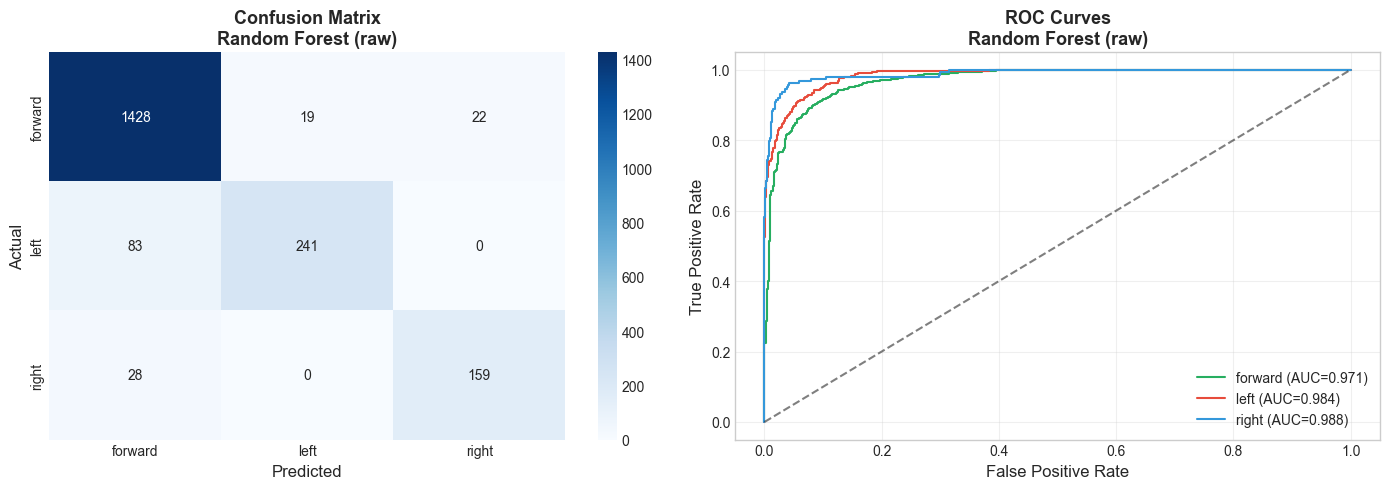

In [5]:
# Evaluate best model on RAW features
print("Evaluating best Random Forest on RAW (PCA) features...")

best_rf_raw = grid_search_raw.best_estimator_
print(f"OOB Score: {best_rf_raw.oob_score_:.4f}")

results_rf_raw = evaluate_model(
    best_rf_raw,
    raw_processed['X_test'],
    raw_processed['y_test'],
    model_name='Random Forest',
    feature_type='raw',
    label_encoder=raw_processed['label_encoder']
)


Evaluating best Random Forest on ENGINEERED features...
OOB Score: 0.8888

Model: Random Forest | Features: engineered
Accuracy:          0.8919
Balanced Accuracy: 0.8520
Macro F1:          0.8365
Weighted F1:       0.8930
Macro Precision:   0.8231
Macro Recall:      0.8520
ROC-AUC (macro):   0.9637

Per-class metrics:
  forward   : F1=0.9265, Precision=0.9355, Recall=0.9176
  left      : F1=0.8111, Precision=0.8073, Recall=0.8148
  right     : F1=0.7719, Precision=0.7264, Recall=0.8235

Classification Report:
              precision    recall  f1-score   support

     forward       0.94      0.92      0.93      1469
        left       0.81      0.81      0.81       324
       right       0.73      0.82      0.77       187

    accuracy                           0.89      1980
   macro avg       0.82      0.85      0.84      1980
weighted avg       0.89      0.89      0.89      1980



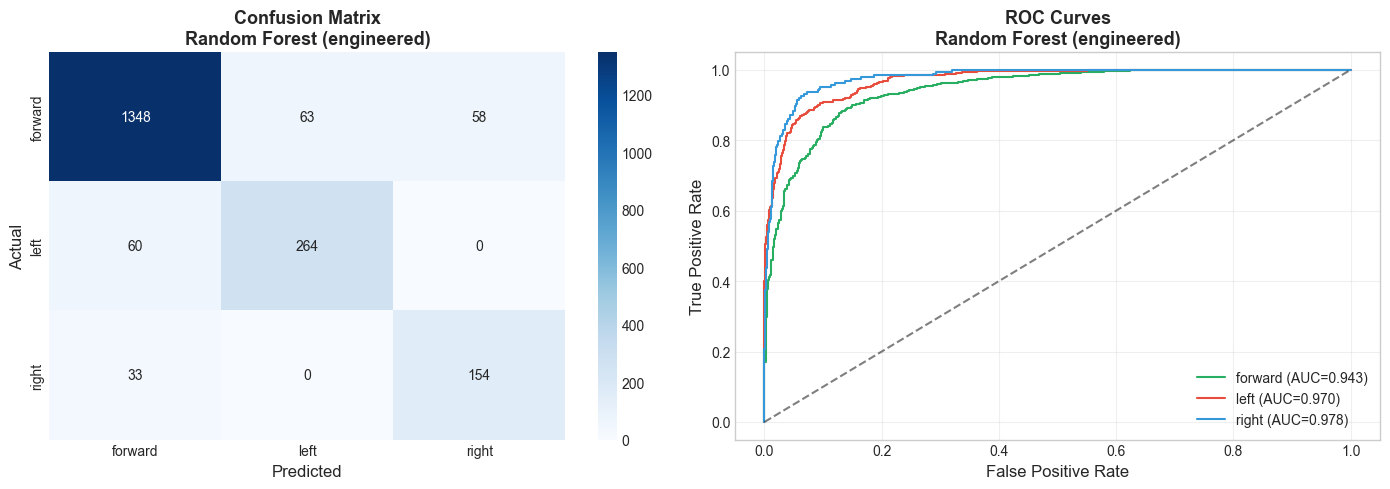

In [6]:
# Evaluate best model on ENGINEERED features
print("Evaluating best Random Forest on ENGINEERED features...")

best_rf_eng = grid_search_eng.best_estimator_
print(f"OOB Score: {best_rf_eng.oob_score_:.4f}")

results_rf_eng = evaluate_model(
    best_rf_eng,
    eng_processed['X_test'],
    eng_processed['y_test'],
    model_name='Random Forest',
    feature_type='engineered',
    label_encoder=eng_processed['label_encoder']
)


## 4. Feature Importance Analysis


Feature Importance (Engineered Features):
   1. quad_bl_mean             : 0.1233
   2. brightness_center_x      : 0.1085
   3. lr_ratio                 : 0.0891
   4. lr_asymmetry             : 0.0872
   5. quad_tr_mean             : 0.0545
   6. quad_br_mean             : 0.0539
   7. diag_asymmetry           : 0.0516
   8. skewness                 : 0.0499
   9. kurtosis                 : 0.0359
  10. quad_tl_mean             : 0.0340
  11. iqr                      : 0.0312
  12. percentile_25            : 0.0253
  13. tb_diff                  : 0.0199
  14. glcm_energy              : 0.0195
  15. edge_hv_ratio            : 0.0192


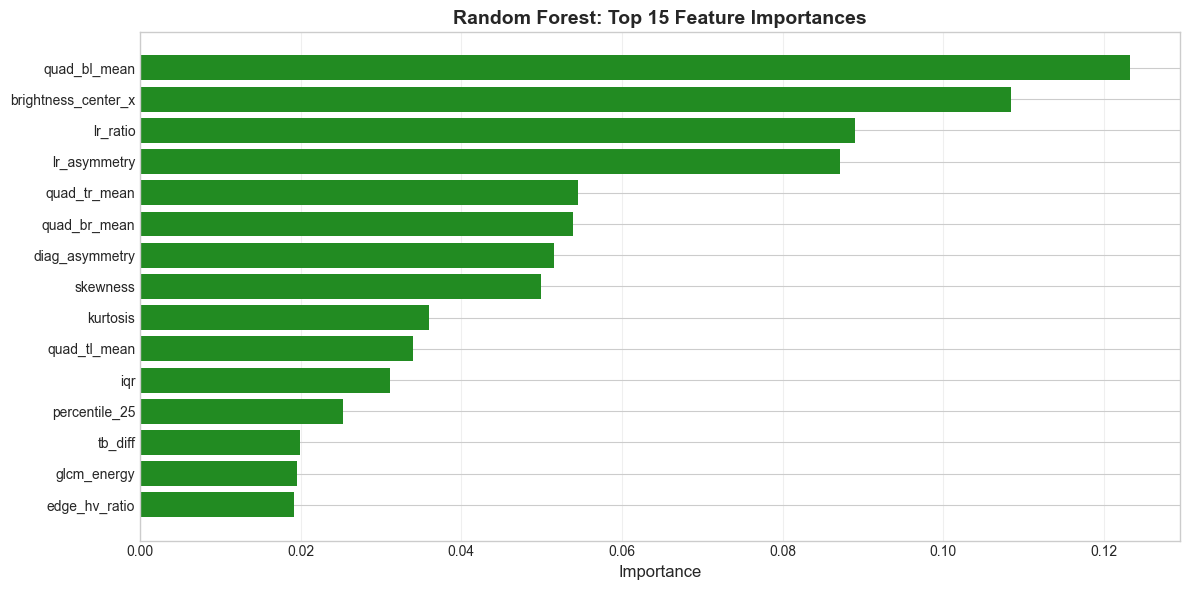

In [7]:
# Feature importance for engineered features
print("Feature Importance (Engineered Features):")
print("="*50)

importances = best_rf_eng.feature_importances_
indices = np.argsort(importances)[::-1]

for i in range(min(15, len(feature_names))):
    idx = indices[i]
    print(f"  {i+1:2d}. {feature_names[idx]:25s}: {importances[idx]:.4f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 6))
top_n = 15
top_indices = indices[:top_n]

ax.barh(range(top_n), importances[top_indices], color='forestgreen')
ax.set_yticks(range(top_n))
ax.set_yticklabels([feature_names[i] for i in top_indices])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Random Forest: Top 15 Feature Importances', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 5. Results Summary


In [8]:
# Summary
all_results = [results_rf_raw, results_rf_eng]

summary_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Features': r['feature_type'],
        'Accuracy': r['accuracy'],
        'Balanced Acc': r['balanced_accuracy'],
        'F1 (Macro)': r['f1_macro'],
        'ROC-AUC': r['roc_auc']
    }
    for r in all_results
])

print("\n" + "="*80)
print("RANDOM FOREST RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))



RANDOM FOREST RESULTS SUMMARY
        Model   Features  Accuracy  Balanced Acc  F1 (Macro)  ROC-AUC
Random Forest        raw  0.923232      0.855395    0.879647 0.980903
Random Forest engineered  0.891919      0.851992    0.836483 0.963663


In [9]:
# Save results
save_results(all_results, 'random_forest')
print("Results saved successfully!")


Results saved to ../../data/model_results/random_forest_results.json
Results saved successfully!


## 6. Key Observations

### Random Forest Advantages
- Decorrelated trees via random feature selection
- Out-of-bag (OOB) error provides built-in validation
- Feature importance for interpretability
- Handles high-dimensional data well

### Tuning Parameters
- `n_estimators`: More trees = lower variance (diminishing returns)
- `max_features`: Controls randomness (√p typical for classification)
- `max_depth`: Limits tree complexity

### Variable Importance
- Measured by decrease in accuracy when variable is permuted in OOB samples
- Average importance across all trees
- Provides insight into which features drive predictions
